# Setting up

Run the following commands to setup your virtual environment and install the dependencies. </br>
``python -m venv .venv`` </br>
```pip install -r requirements.txt```

# Imports

In [51]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, BackendSampler
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import VQD, VQE, SamplingVQE, NumPyEigensolver
from qiskit_algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit_algorithms.gradients import DerivativeType, LinCombQGT, LinCombEstimatorGradient
from qiskit_algorithms.state_fidelities import BaseStateFidelity, ComputeUncompute

from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition
from qiskit_nature.second_q.hamiltonians.ising_model import IsingModel
from qiskit.quantum_info import Operator
# from qiskit.quantum_info.operators.base_operator import BaseOperator

import matplotlib.pyplot as plt

from qiskit import Aer, transpile
import numpy as np
from qiskit.tools.visualization import plot_histogram

We are first going to use Aer to test our code and once we have it working we can increase the number of qubits and submit a job to the Quantinuum emulator

In [29]:
simulator_aer = Aer.get_backend('aer_simulator')

In [3]:
class Params:
    def __init__(self, num_qubits: int, no_of_states_to_compute: int, use_quant, 
                 uniform_interaction, uniform_onsite_potential):
        self.num_qubits = num_qubits
        self.no_of_states_to_compute = no_of_states_to_compute
        self.hamiltonian_op = self.__get_hamiltonian__(uniform_interaction, uniform_onsite_potential)
        self.use_quant = use_quant
    
            
    
    def __get_hamiltonian__(self, uniform_interaction, uniform_onsite_potential):
        line_lattice = LineLattice(num_nodes=self.num_qubits, boundary_condition=BoundaryCondition.OPEN)

        ising_model = IsingModel(
            line_lattice.uniform_parameters(
                uniform_interaction,
                uniform_onsite_potential
            ),
        )
        ham = ising_model.second_q_op()
        ham_operator = Operator(ham.to_matrix())
        eivs = list(np.linalg.eigvals(ham_operator))
        eivs.sort()
        # print('numpy soln', eivs)
        return SparsePauliOp.from_operator(ham_operator)

In [4]:
counts = []
values = []
steps = []

def reset_counts_values_steps():
    global counts
    global values
    global steps
    counts = []
    values = []
    steps = []
    
def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [44]:
def aer_sim():
    # set parameters
    optimizer_cobyla = COBYLA(maxiter=500)
    params = Params(num_qubits = 3, no_of_states_to_compute = 6, use_quant = False, 
                    uniform_interaction=-1.0, uniform_onsite_potential=-0.4)
    betas = [1]*params.no_of_states_to_compute
    ansatz = EfficientSU2(params.num_qubits, entanglement="linear")

    estimator = Estimator()
    sampler = BackendSampler(simulator_aer)
    fidelity = ComputeUncompute(sampler)

    vqd = VQD(estimator, fidelity, ansatz, optimizer_cobyla, k=params.no_of_states_to_compute, betas=betas, callback=callback)
    vqd_result = vqd.compute_eigenvalues(params.hamiltonian_op)
    print('VQD res: ', vqd_result.eigenvalues.real)

    exact_solver = NumPyEigensolver(k=params.no_of_states_to_compute)
    exact_result = exact_solver.compute_eigenvalues(params.hamiltonian_op)
    ref_values = exact_result.eigenvalues
    print('Sim res: ', ref_values)

    steps_np = np.asarray(steps)
    counts_np = np.asarray(counts)
    values_np = np.asarray(values)
    reset_counts_values_steps()

    for i in range(1, params.no_of_states_to_compute+1):
        _counts = counts_np[np.where(steps_np == i)]
        _values = values_np[np.where(steps_np == i)]
        plt.plot(_counts, _values, label=f"State {i-1}")

    plt.xlabel("Eval count")
    plt.ylabel("Energy")
    plt.title("Energy convergence for each computed state")
    plt.legend(loc="upper right")
    plt.show()
    return vqd_result


VQD res:  [-0.75120505 -0.57820142 -0.16669719  0.11417448  0.24295256  0.24745488]
Sim res:  [-0.75225553 -0.60900802 -0.2        -0.05675249  0.05675249  0.2       ]


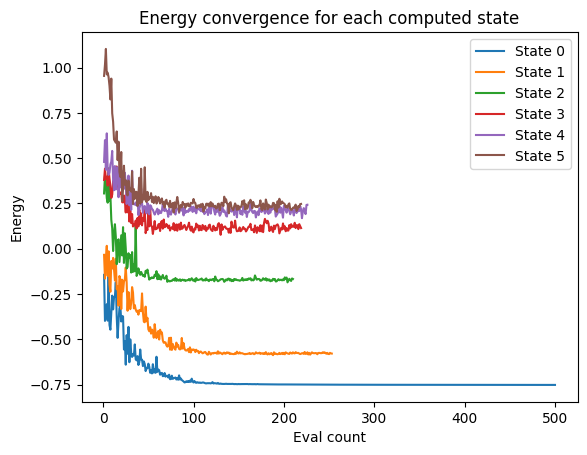

In [45]:
vqd_result = aer_sim()

# Transition Probability

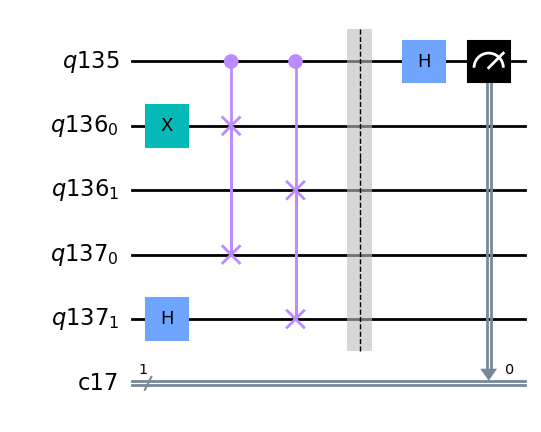

In [46]:
qregs_0 = QuantumRegister(1)
creg = ClassicalRegister(1)
qregs_1 = QuantumRegister(2)
qregs_2 = QuantumRegister(2)
qc = QuantumCircuit(qregs_0, qregs_1, qregs_2, creg)
qc_final = QuantumCircuit(qregs_1)
qc_final.x(0)
qc_initial = QuantumCircuit(qregs_2)
qc_initial.h(1)
qc = qc.compose(qc_final, qregs_1)
qc = qc.compose(qc_initial, qregs_2)

for i in range(2):
    qc.cswap(0, qregs_1[i], qregs_2[i])
qc.barrier()
qc.h(0)
qc.measure(0, creg)
qc.draw('mpl')

In [63]:
def calculate_transition_prob(qc_final: QuantumCircuit, qc_initial: QuantumCircuit):
    assert qc_final.num_qubits == qc_initial.num_qubits
    qregs_0 = QuantumRegister(1)
    creg = ClassicalRegister(1)
    qregs_1 = QuantumRegister(qc_final.num_qubits)
    qregs_2 = QuantumRegister(qc_initial.num_qubits)
    qc = QuantumCircuit(qregs_0, qregs_1, qregs_2, creg)
    qc = qc.compose(qc_final, qregs_1)
    qc = qc.compose(qc_initial, qregs_2)
    qc.h(0)
    for i in range(qc_final.num_qubits):
        qc.cswap(0, qregs_1[i], qregs_2[i])
    qc.barrier()
    qc.h(0)
    qc.measure(0, creg)
    circ = transpile(qc, simulator_aer)
    shots = 100
    # display(qc.draw('mpl'))
    result = simulator_aer.run(circ, shots=shots).result()
    counts = result.get_counts(circ)
    display(plot_histogram(counts))
    return ((counts['0']/shots - 0.5)*2)**(0.5)
    

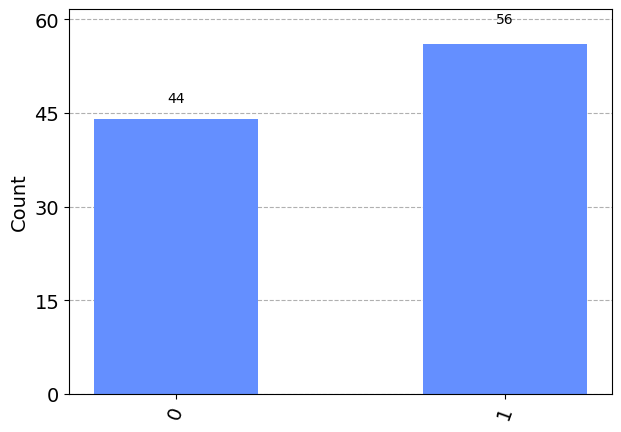

Transition prob:  (2.121150477449814e-17+0.34641016151377546j)


In [66]:
transition_prob = calculate_transition_prob(vqd_result.optimal_circuits[0].bind_parameters(vqd_result.optimal_parameters[0]), 
                          vqd_result.optimal_circuits[1].bind_parameters(vqd_result.optimal_parameters[1]))
print('Transition prob: ', transition_prob)